In [1]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [3]:
data = pd.read_csv('synthetic_drug_target_interaction.csv')

In [4]:
data.shape

(1000, 51)

In [6]:
X = data.drop('interaction', axis=1).values
y = data['interaction'].values

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
def build_model(hp):  # hp is passed by the tuner
    model = Sequential()
    # Input Layer
    model.add(Dense(units=hp.Int('units_input', min_value=32, max_value=512, step=32), activation='relu', input_shape=(X_train.shape[1],)))

    # Adding Hidden Layers based on Hyperparameters
    for i in range(hp.Int('num_layers', 1, 3)):  # The number of hidden layers is tuned
        model.add(Dense(units=hp.Int(f'units_{i}', min_value=32, max_value=512, step=32), activation='relu'))
        model.add(Dropout(hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)))

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output

    # Compile Model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('lr', 1e-4, 1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

In [12]:
from keras_tuner.tuners import Hyperband

In [13]:
tuner = Hyperband(
    build_model,  # Pass the build_model function here
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='hyperband',
    project_name='drug_target_interaction'
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
tuner.search(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)

Trial 30 Complete [00h 00m 04s]
val_accuracy: 0.5062500238418579

Best val_accuracy So Far: 0.5625
Total elapsed time: 00h 01m 47s


Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.5958 - loss: 0.6789 - val_accuracy: 0.5562 - val_loss: 0.6871
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6366 - loss: 0.6572 - val_accuracy: 0.5625 - val_loss: 0.6889
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6179 - loss: 0.6565 - val_accuracy: 0.5750 - val_loss: 0.6873
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6435 - loss: 0.6509 - val_accuracy: 0.5750 - val_loss: 0.6909
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6600 - loss: 0.6165 - val_accuracy: 0.5437 - val_loss: 0.6964
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7513 - loss: 0.5938 - val_accuracy: 0.5562 - val_loss: 0.7124
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7402 - loss: 0.5706 - val_accuracy: 0.5312 - val_loss: 0.7283
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7457 - loss: 0.5448 - val_accuracy: 0.5312 - val_l

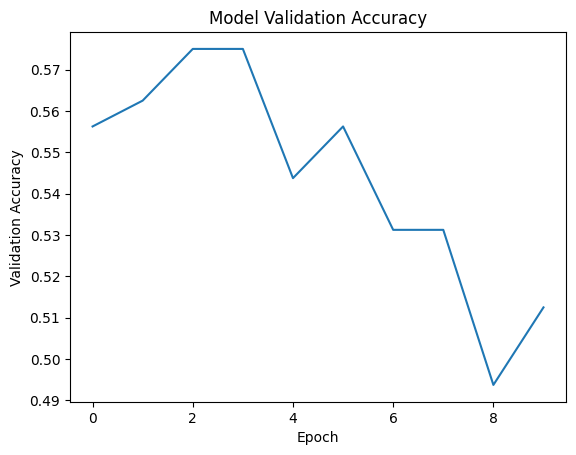

In [15]:
import matplotlib.pyplot as plt

# Get the best hyperparameters and the corresponding model
best_hp = tuner.get_best_hyperparameters()[0]
best_model = tuner.get_best_models()[0]

# Get the training history for the best model
history = best_model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)

# Plot the validation accuracy over epochs
plt.plot(history.history['val_accuracy'])
plt.title('Model Validation Accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('Epoch')
plt.show()

In [16]:
best_model = tuner.get_best_models(num_models=1)[0]

In [17]:
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4641 - loss: 0.6988  
Test Accuracy: 0.4700


In [18]:
history = best_model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)
print(history.history.keys())  # Print the available keys

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.5945 - loss: 0.6770 - val_accuracy: 0.5375 - val_loss: 0.6929
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6006 - loss: 0.6682 - val_accuracy: 0.5375 - val_loss: 0.6893
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6357 - loss: 0.6541 - val_accuracy: 0.5750 - val_loss: 0.6863
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6665 - loss: 0.6420 - val_accuracy: 0.5500 - val_loss: 0.6932
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7193 - loss: 0.6000 - val_accuracy: 0.5562 - val_loss: 0.6968
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7119 - loss: 0.5901 - val_accuracy: 0.5312 - val_loss: 0.7158
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7223 - loss: 0.5608 - val_accuracy: 0.5312 - val_loss: 0.7287
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7505 - loss: 0.5231 - val_accuracy: 0.5250 - va

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8172 - loss: 0.4451 - val_accuracy: 0.4812 - val_loss: 0.8579
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8503 - loss: 0.3802 - val_accuracy: 0.4812 - val_loss: 0.9171
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8879 - loss: 0.3189 - val_accuracy: 0.5188 - val_loss: 0.9799
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8986 - loss: 0.3084 - val_accuracy: 0.4812 - val_loss: 1.0457
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9153 - loss: 0.2699 - val_accuracy: 0.4938 - val_loss: 1.1429
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9219 - loss: 0.2413 - val_accuracy: 0.5188 - val_loss: 1.2420
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9370 - loss: 0.1941 - val_accuracy: 0.4812 - val_loss: 1.3345
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9663 - loss: 0.1693 - val_accuracy: 0.4938 - val_l

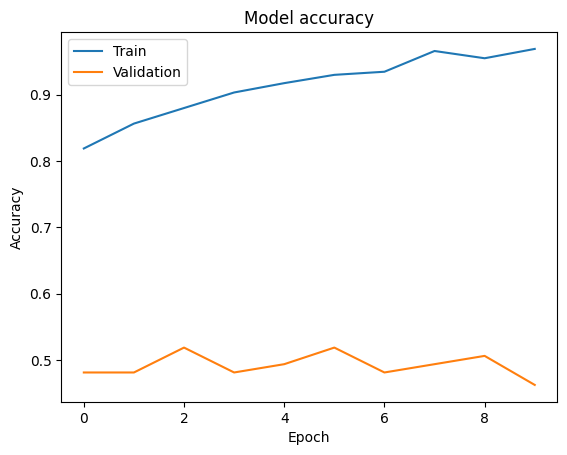

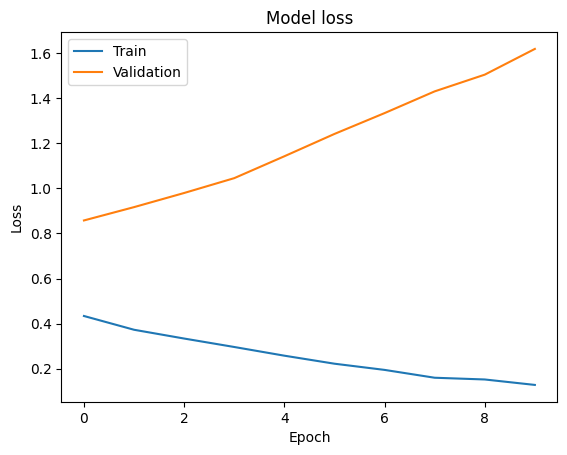

In [19]:
import matplotlib.pyplot as plt

history = best_model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

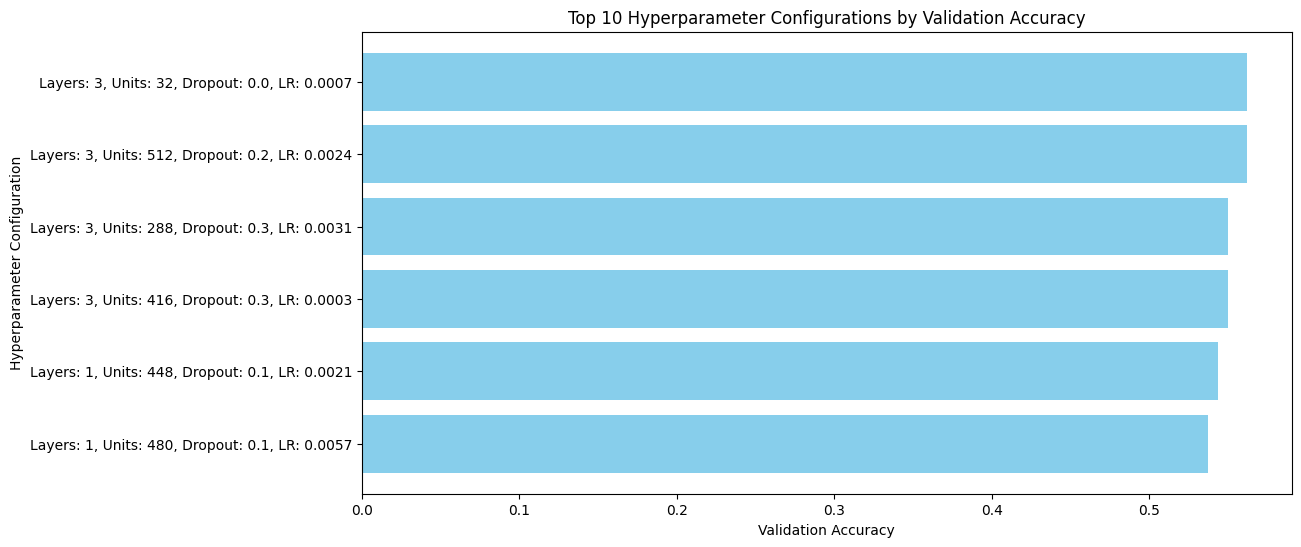

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Retrieve the top trials from Hyperband
trials = tuner.oracle.get_best_trials(num_trials=10)  # Get top 10 trials

# Store results
val_accuracies = []
configurations = []

# Loop through the trials and extract the validation accuracy and hyperparameters
for trial in trials:
    val_accuracy = trial.metrics.get_last_value('val_accuracy')  # Get validation accuracy
    val_accuracies.append(val_accuracy)

    # Extract hyperparameters used for the trial
    config = trial.hyperparameters.values
    config_summary = f"Layers: {config['num_layers']}, Units: {config['units_input']}, Dropout: {config['dropout_0']:.1f}, LR: {config['lr']:.4f}"
    configurations.append(config_summary)

# Convert the results into a DataFrame
results_df = pd.DataFrame({'Configuration': configurations, 'Validation Accuracy': val_accuracies})

# Plotting the results using a bar chart
plt.figure(figsize=(12, 6))
plt.barh(results_df['Configuration'], results_df['Validation Accuracy'], color='skyblue')
plt.xlabel('Validation Accuracy')
plt.ylabel('Hyperparameter Configuration')
plt.title('Top 10 Hyperparameter Configurations by Validation Accuracy')
plt.gca().invert_yaxis()  # Invert the Y-axis to display the best configurations at the top
plt.show()


In [21]:
# Access all the trials from Hyperband
trials = tuner.oracle.get_best_trials(num_trials=10)  # Get the top 10 trials

# Print the hyperparameters and corresponding validation accuracy of each trial
for trial in trials:
    print(f"Trial ID: {trial.trial_id}")
    print(f"Hyperparameters: {trial.hyperparameters.values}")
    print(f"Validation Accuracy: {trial.metrics.get_last_value('val_accuracy')}")
    print("------")


Trial ID: 0022
Hyperparameters: {'units_input': 32, 'num_layers': 3, 'units_0': 64, 'dropout_0': 0.0, 'lr': 0.0007296560092028349, 'units_1': 64, 'dropout_1': 0.2, 'units_2': 160, 'dropout_2': 0.2, 'tuner/epochs': 4, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
Validation Accuracy: 0.5625
------
Trial ID: 0024
Hyperparameters: {'units_input': 32, 'num_layers': 3, 'units_0': 64, 'dropout_0': 0.0, 'lr': 0.0007296560092028349, 'units_1': 64, 'dropout_1': 0.2, 'units_2': 160, 'dropout_2': 0.2, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0022'}
Validation Accuracy: 0.5625
------
Trial ID: 0028
Hyperparameters: {'units_input': 512, 'num_layers': 3, 'units_0': 352, 'dropout_0': 0.2, 'lr': 0.0024305409582891496, 'units_1': 320, 'dropout_1': 0.2, 'units_2': 32, 'dropout_2': 0.0, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Validation Accuracy: 0.5625
------
Trial ID: 0012
Hyperpa

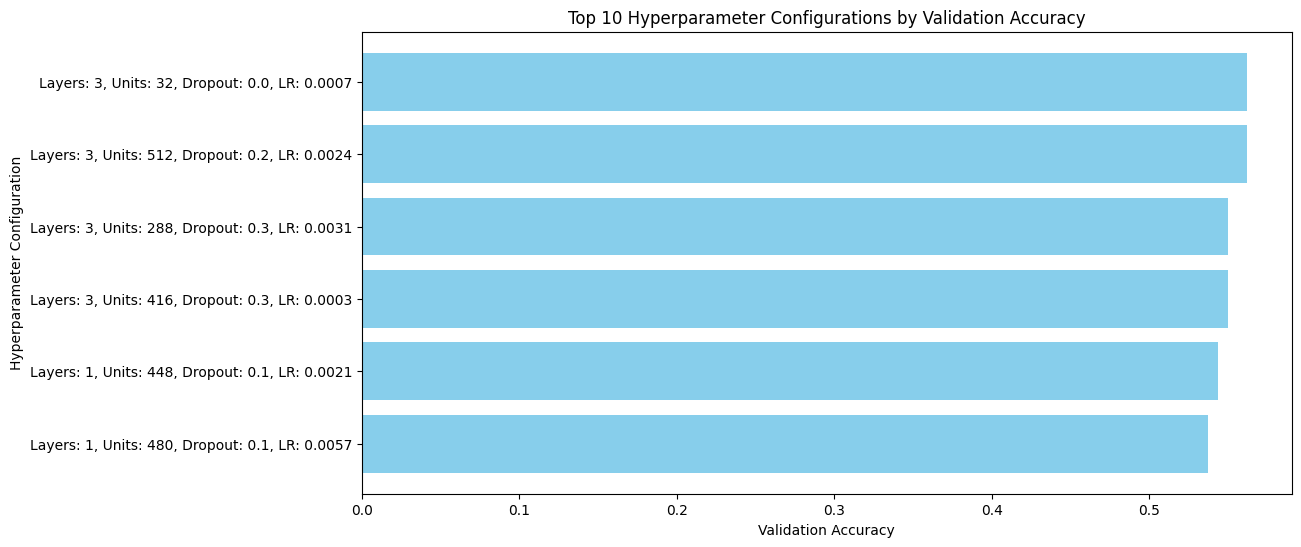

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# Retrieve the top trials from Hyperband
trials = tuner.oracle.get_best_trials(num_trials=10)  # Get top 10 trials

# Store results
val_accuracies = []
configurations = []

# Loop through the trials and extract the validation accuracy and hyperparameters
for trial in trials:
    val_accuracy = trial.metrics.get_last_value('val_accuracy')  # Get validation accuracy
    val_accuracies.append(val_accuracy)

    # Extract hyperparameters used for the trial
    config = trial.hyperparameters.values
    config_summary = f"Layers: {config['num_layers']}, Units: {config['units_input']}, Dropout: {config['dropout_0']:.1f}, LR: {config['lr']:.4f}"
    configurations.append(config_summary)

# Convert the results into a DataFrame
results_df = pd.DataFrame({'Configuration': configurations, 'Validation Accuracy': val_accuracies})

# Plotting the results using a bar chart
plt.figure(figsize=(12, 6))
plt.barh(results_df['Configuration'], results_df['Validation Accuracy'], color='skyblue')
plt.xlabel('Validation Accuracy')
plt.ylabel('Hyperparameter Configuration')
plt.title('Top 10 Hyperparameter Configurations by Validation Accuracy')
plt.gca().invert_yaxis()  # Invert the Y-axis to display the best configurations at the top
plt.show()

In [23]:
# Retrieve the best trials from Hyperband
best_trials = tuner.oracle.get_best_trials(num_trials=10)  # Get top 10 trials

# Print hyperparameters and validation accuracy for each trial
for trial in best_trials:
    print(f"Trial ID: {trial.trial_id}")
    print(f"Hyperparameters: {trial.hyperparameters.values}")
    print(f"Validation Accuracy: {trial.metrics.get_last_value('val_accuracy')}")
    print("------")


Trial ID: 0022
Hyperparameters: {'units_input': 32, 'num_layers': 3, 'units_0': 64, 'dropout_0': 0.0, 'lr': 0.0007296560092028349, 'units_1': 64, 'dropout_1': 0.2, 'units_2': 160, 'dropout_2': 0.2, 'tuner/epochs': 4, 'tuner/initial_epoch': 0, 'tuner/bracket': 1, 'tuner/round': 0}
Validation Accuracy: 0.5625
------
Trial ID: 0024
Hyperparameters: {'units_input': 32, 'num_layers': 3, 'units_0': 64, 'dropout_0': 0.0, 'lr': 0.0007296560092028349, 'units_1': 64, 'dropout_1': 0.2, 'units_2': 160, 'dropout_2': 0.2, 'tuner/epochs': 10, 'tuner/initial_epoch': 4, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0022'}
Validation Accuracy: 0.5625
------
Trial ID: 0028
Hyperparameters: {'units_input': 512, 'num_layers': 3, 'units_0': 352, 'dropout_0': 0.2, 'lr': 0.0024305409582891496, 'units_1': 320, 'dropout_1': 0.2, 'units_2': 32, 'dropout_2': 0.0, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Validation Accuracy: 0.5625
------
Trial ID: 0012
Hyperpa

In [24]:
import pandas as pd

# Retrieve the best trials
best_trials = tuner.oracle.get_best_trials(num_trials=10)  # Get the top 10 trials

# Store trial data in a list for easy conversion to DataFrame
trial_data = []

# Iterate over the best trials and extract data
for trial in best_trials:
    trial_info = {
        'Trial ID': trial.trial_id,
        'Validation Accuracy': trial.metrics.get_last_value('val_accuracy'),
        'Learning Rate': trial.hyperparameters.get('lr'),
        'Num Layers': trial.hyperparameters.get('num_layers'),
        'Units Input': trial.hyperparameters.get('units_input')
    }
    trial_data.append(trial_info)

# Convert to DataFrame for better readability
df_trials = pd.DataFrame(trial_data)

# Sort the DataFrame by validation accuracy (descending)
df_trials_sorted = df_trials.sort_values(by='Validation Accuracy', ascending=False)

# Display the sorted trials
print(df_trials_sorted)

# Optionally, save to a CSV file
df_trials_sorted.to_csv('hyperband_trials.csv', index=False)


  Trial ID  Validation Accuracy  Learning Rate  Num Layers  Units Input
0     0022              0.56250       0.000730           3           32
1     0024              0.56250       0.000730           3           32
2     0028              0.56250       0.002431           3          512
3     0012              0.55000       0.003119           3          288
4     0025              0.55000       0.000307           3          416
5     0014              0.54375       0.002086           1          448
6     0001              0.53750       0.003119           3          288
7     0006              0.53750       0.005719           1          480
8     0016              0.53750       0.003119           3          288
9     0020              0.53750       0.000307           3          416


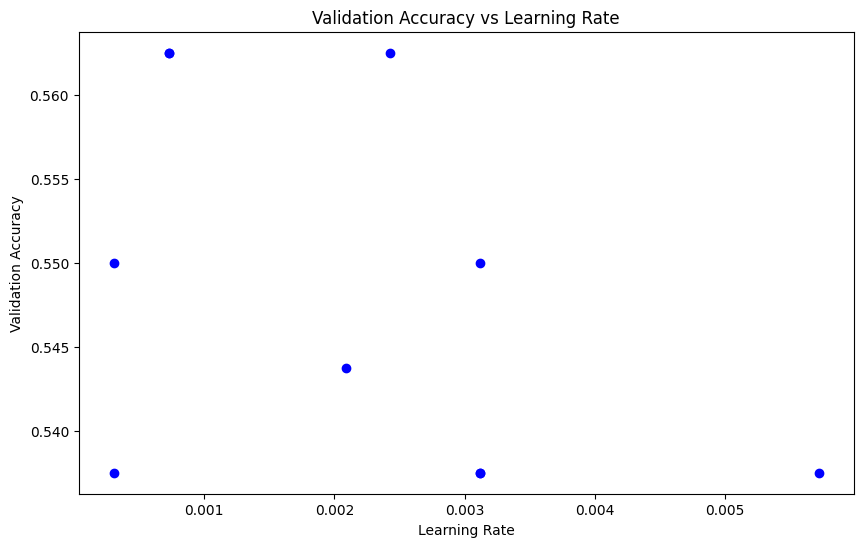

In [25]:
import matplotlib.pyplot as plt

# Plot Validation Accuracy vs Learning Rate
plt.figure(figsize=(10, 6))

# Extract learning rates and validation accuracies
learning_rates = df_trials_sorted['Learning Rate']
val_accuracies = df_trials_sorted['Validation Accuracy']

# Create a scatter plot
plt.scatter(learning_rates, val_accuracies, color='blue')
plt.xlabel('Learning Rate')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Learning Rate')
plt.show()


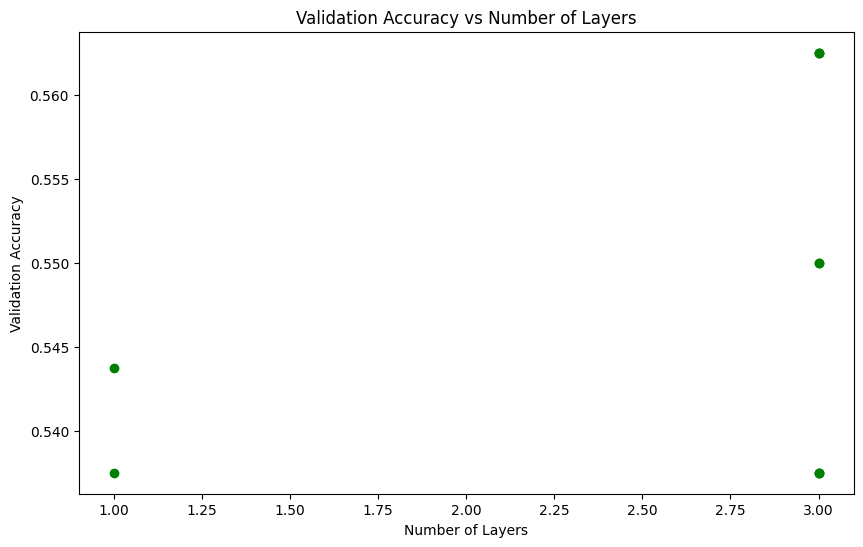

In [26]:
# Plot Validation Accuracy vs Number of Layers
plt.figure(figsize=(10, 6))

# Extract number of layers and validation accuracies
num_layers = df_trials_sorted['Num Layers']
val_accuracies = df_trials_sorted['Validation Accuracy']

# Create a scatter plot
plt.scatter(num_layers, val_accuracies, color='green')
plt.xlabel('Number of Layers')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Number of Layers')
plt.show()


In [27]:
pip install pydot graphviz


In [28]:
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the Model Architecture
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(10,)))  # Example input layer with 10 features

# Add hidden layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(1, activation='sigmoid'))  # Binary classification output

# Plot the model architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

print("Model architecture saved as 'model_architecture.png'")


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model architecture saved as 'model_architecture.png'


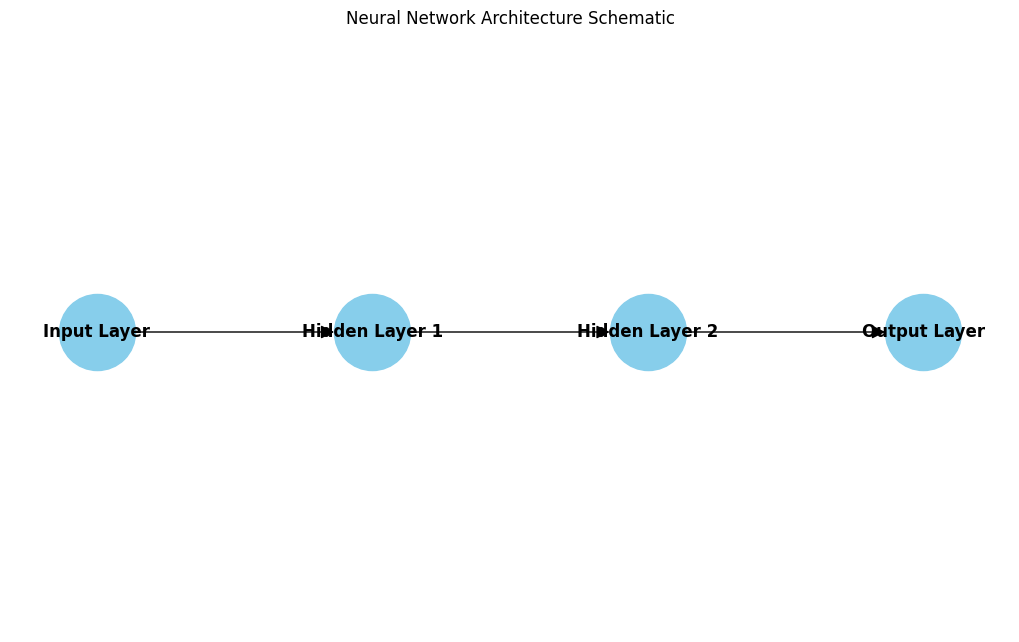

In [29]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph to represent the layers
G = nx.DiGraph()

# Add nodes (representing layers)
G.add_node("Input Layer", layer_type="input")
G.add_node("Hidden Layer 1", layer_type="hidden")
G.add_node("Hidden Layer 2", layer_type="hidden")
G.add_node("Output Layer", layer_type="output")

# Add edges (representing data flow)
G.add_edge("Input Layer", "Hidden Layer 1")
G.add_edge("Hidden Layer 1", "Hidden Layer 2")
G.add_edge("Hidden Layer 2", "Output Layer")

# Draw the network
pos = {
    "Input Layer": (0, 1),
    "Hidden Layer 1": (1, 1),
    "Hidden Layer 2": (2, 1),
    "Output Layer": (3, 1)
}
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='skyblue', font_size=12, font_weight='bold', arrowsize=20)
plt.title('Neural Network Architecture Schematic')
plt.show()


In [30]:

from sklearn.metrics import mean_squared_error

In [31]:
y_pred = best_model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [32]:
y_pred_binary = (y_pred > 0.5).astype(int)

In [33]:
mse = mean_squared_error(y_test, y_pred_binary)
print(f"Mean Squared Error: {mse:.4f}")


Mean Squared Error: 0.4550


In [34]:
from sklearn.metrics import mean_squared_error
y_pred = best_model.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)
mse = mean_squared_error(y_test, y_pred_binary)
print(f"Mean Squared Error: {mse:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Mean Squared Error: 0.4550


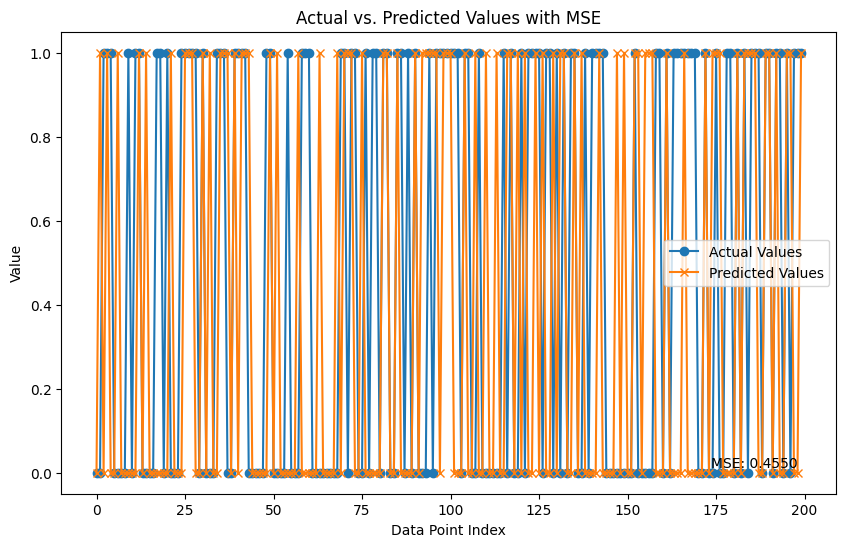

In [35]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you already have y_test and y_pred_binary

# Create an array of indices for plotting
index = np.arange(len(y_test))

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(index, y_test, label='Actual Values', marker='o')
plt.plot(index, y_pred_binary, label='Predicted Values', marker='x')
plt.title('Actual vs. Predicted Values with MSE')
plt.xlabel('Data Point Index')
plt.ylabel('Value')
plt.legend()

# Add the MSE value to the plot (you can adjust the position)
plt.text(0.95, 0.05, f'MSE: {mse:.4f}', ha='right', va='bottom', transform=plt.gca().transAxes)

plt.show()

In [36]:
from tensorflow.keras.utils import plot_model

In [37]:
mse_values = []

In [38]:
def collect_mse_trial(trial):
    # Get the trial's model and history
    model = tuner.oracle.get_trial(trial.trial_id).best_model
    # Predicting the test set
    y_pred = model.predict(X_test)
    # Convert predicted probabilities to binary outcomes
    y_pred_binary = (y_pred > 0.5).astype(int)

    # Calculate Mean Squared Error (MSE)
    mse = mean_squared_error(y_test, y_pred_binary)
    mse_values.append(mse)

# Start the Hyperband search with the custom callback
tuner.search(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32, callbacks=[collect_mse_trial])

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5933 - loss: 0.6788 - val_accuracy: 0.5312 - val_loss: 0.6914
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5967 - loss: 0.6602 - val_accuracy: 0.5500 - val_loss: 0.6899
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6033 - loss: 0.6628 - val_accuracy: 0.5562 - val_loss: 0.6898
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6481 - loss: 0.6383 - val_accuracy: 0.5625 - val_loss: 0.6934
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6870 - loss: 0.6127 - val_accuracy: 0.5625 - val_loss: 0.6964
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6789 - loss: 0.6025 - val_accuracy: 0.5437 - val_loss: 0.7101
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7404 - loss: 0.5590 - val_accuracy: 0.5312 - val_loss: 0.7228
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7214 - loss: 0.5544 - val_accuracy: 0.5250 - val_loss: 0.7437
Ep

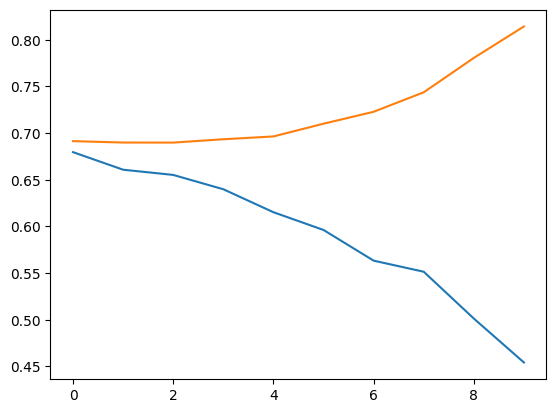

In [39]:
!pip install keras-tuner

from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# ... (Previous code to define tuner, X_train, y_train, X_test, y_test) ...

# Store the best model found by the tuner
best_model = tuner.get_best_models(num_models=1)[0]

# Fit the best model to the training data to get the History object
history = best_model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)

# Plot using the history object
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

# ... (Rest of the code)

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.6064 - loss: 0.6689 - val_accuracy: 0.5500 - val_loss: 0.6879
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6098 - loss: 0.6576 - val_accuracy: 0.5813 - val_loss: 0.6871
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6459 - loss: 0.6496 - val_accuracy: 0.5750 - val_loss: 0.6896
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6297 - loss: 0.6489 - val_accuracy: 0.5813 - val_loss: 0.6910
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6945 - loss: 0.6162 - val_accuracy: 0.5625 - val_loss: 0.6994
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7034 - loss: 0.5983 - val_accuracy: 0.5437 - val_loss: 0.7171
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7363 - loss: 0.5594 - val_accuracy: 0.5312 - val_loss: 0.7325
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7562 - loss: 0.5416 - val_accuracy: 0.4938 - val_l

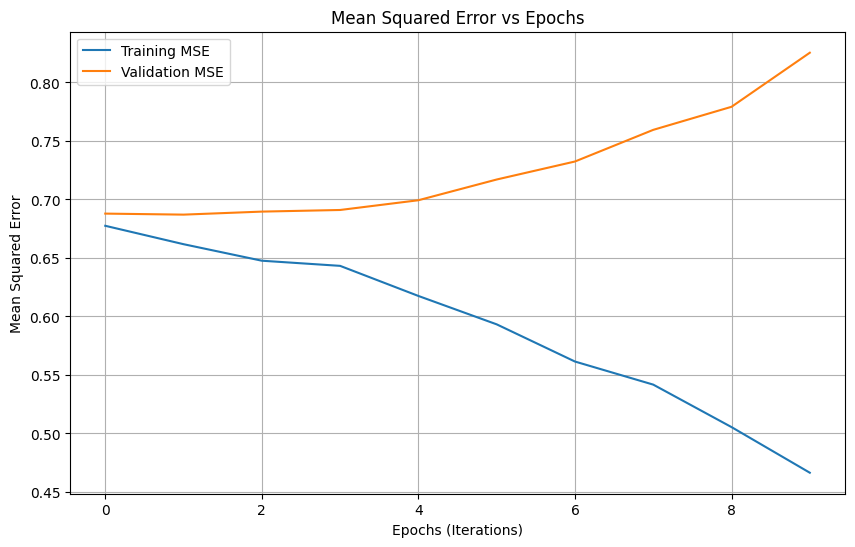

In [40]:
!pip install keras-tuner

from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# ... (Previous code to define tuner, X_train, y_train, X_test, y_test) ...

# Get the best model found by the tuner
best_model = tuner.get_best_models(num_models=1)[0]

# Fit the best model and store history
history = best_model.fit(X_train, y_train, epochs=10, validation_split=0.2, batch_size=32)

# Plot MSE vs Epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training MSE')
plt.plot(history.history['val_loss'], label='Validation MSE')
plt.title('Mean Squared Error vs Epochs')
plt.xlabel('Epochs (Iterations)')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
!pip install keras-tuner
from sklearn.metrics import precision_score, roc_auc_score, recall_score

# ... (Previous code to define tuner, X_train, y_train, X_test, y_test) ...

# Get the best model found by the tuner
best_model = tuner.get_best_models(num_models=1)[0]

# Predict probabilities on the test set
y_pred_proba = best_model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

# Calculate precision, AUC-ROC, and recall
precision = precision_score(y_test, y_pred_binary)
auc_roc = roc_auc_score(y_test, y_pred_proba)
recall = recall_score(y_test, y_pred_binary)

# Print the results
print(f"Precision: {precision:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Recall: {recall:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step
Precision: 0.4718
AUC-ROC: 0.5100
Recall: 0.6837


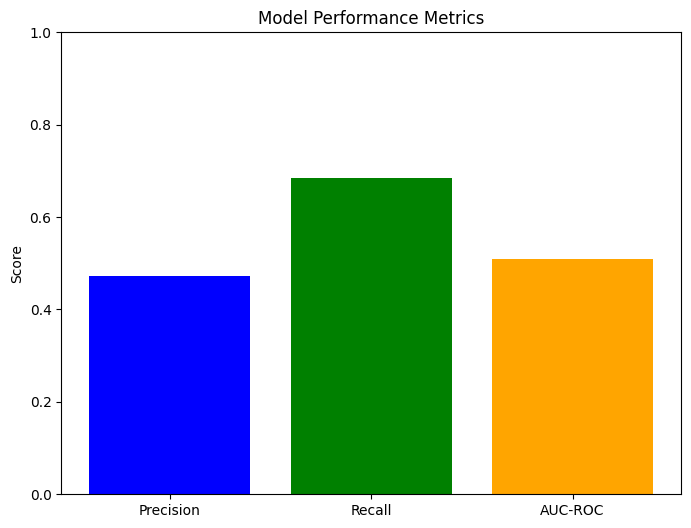

In [42]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already calculated precision, auc_roc, and recall

# Create a bar chart
metrics = ['Precision', 'Recall', 'AUC-ROC']
values = [precision, recall, auc_roc]

plt.figure(figsize=(8, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange'])
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)  # Set y-axis limits to 0-1 for better visualization
plt.show()

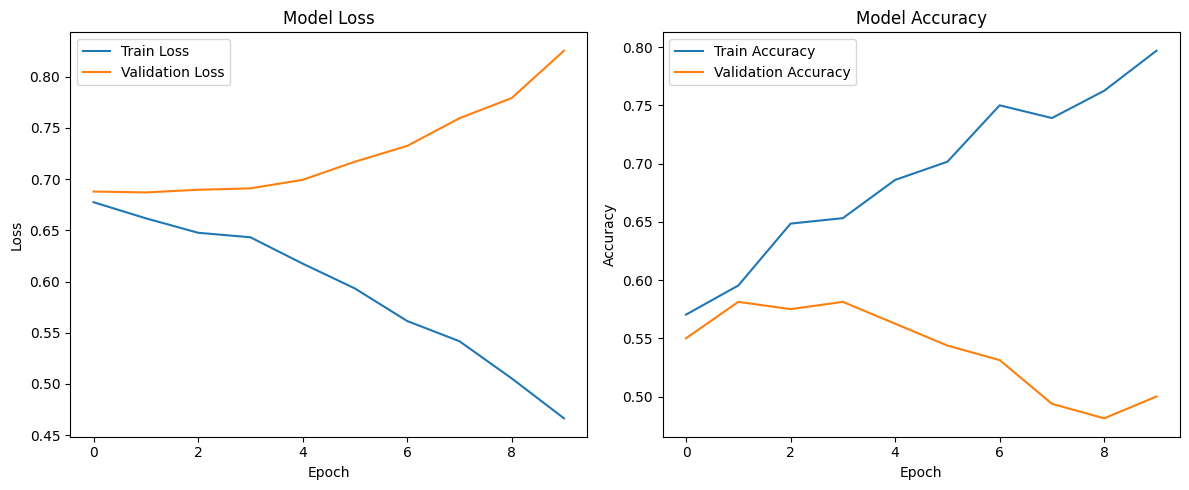

In [43]:
import matplotlib.pyplot as plt

# Assuming you have history from model training
# history = model.fit(...)

# Create subplots for loss and accuracy
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot training & validation loss values
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Model Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

# Plot training & validation accuracy values
axs[1].plot(history.history['accuracy'], label='Train Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Model Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()


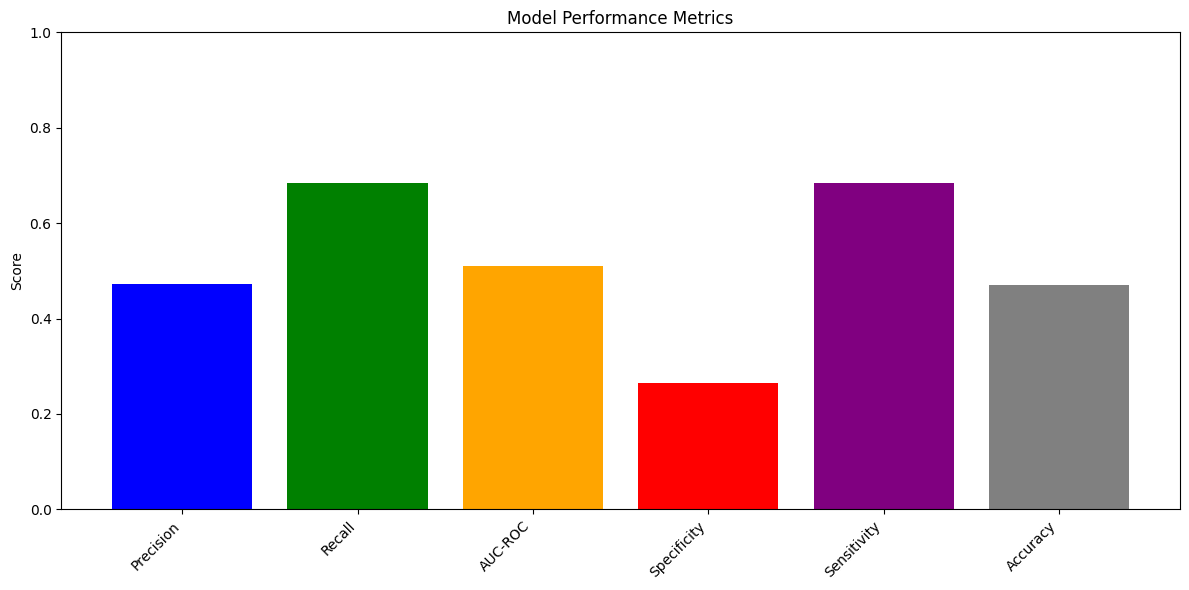

In [44]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

# ... (Previous code to define best_model, y_test, y_pred_binary) ...

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()

# Calculate specificity and sensitivity
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)  # Sensitivity is the same as recall

# Create a bar chart
metrics = ['Precision', 'Recall', 'AUC-ROC', 'Specificity', 'Sensitivity', 'Accuracy']
values = [precision, recall, auc_roc, specificity, sensitivity, accuracy]

plt.figure(figsize=(12, 6))  # Adjust figure size for better readability
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red', 'purple', 'gray'])
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)  # Set y-axis limits to 0-1 for better visualization
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

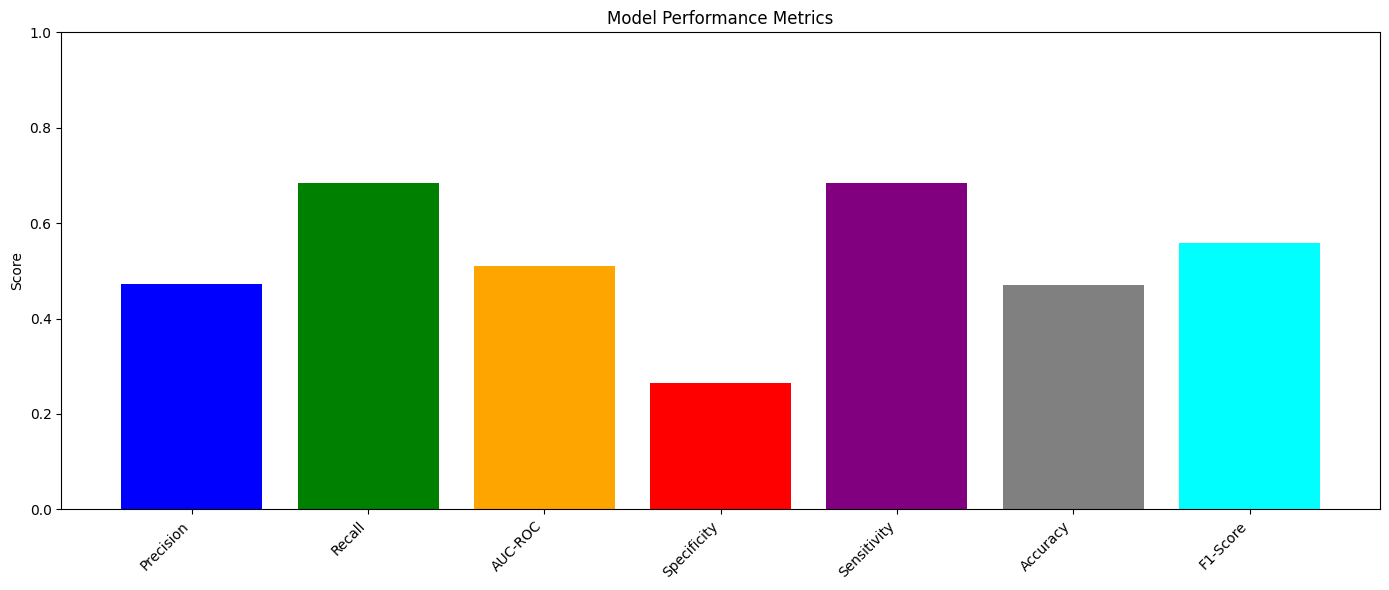

In [45]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

# ... (Previous code to define best_model, y_test, y_pred_binary) ...

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_binary)

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()

# Calculate specificity and sensitivity
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)  # Sensitivity is the same as recall

# Calculate F1-score
f1 = f1_score(y_test, y_pred_binary)

# Create a bar chart
metrics = ['Precision', 'Recall', 'AUC-ROC', 'Specificity', 'Sensitivity', 'Accuracy', 'F1-Score']
values = [precision, recall, auc_roc, specificity, sensitivity, accuracy, f1]

plt.figure(figsize=(14, 6))  # Adjust figure size for better readability
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red', 'purple', 'gray', 'cyan'])
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)  # Set y-axis limits to 0-1 for better visualization
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

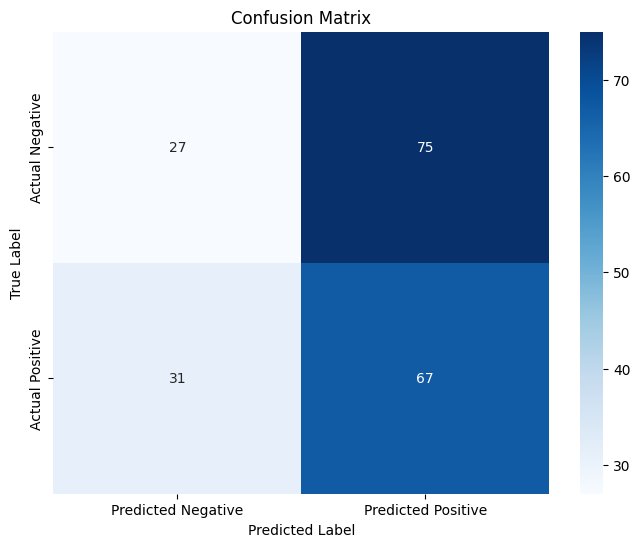

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ... (Previous code to define best_model, y_test, y_pred_binary) ...

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

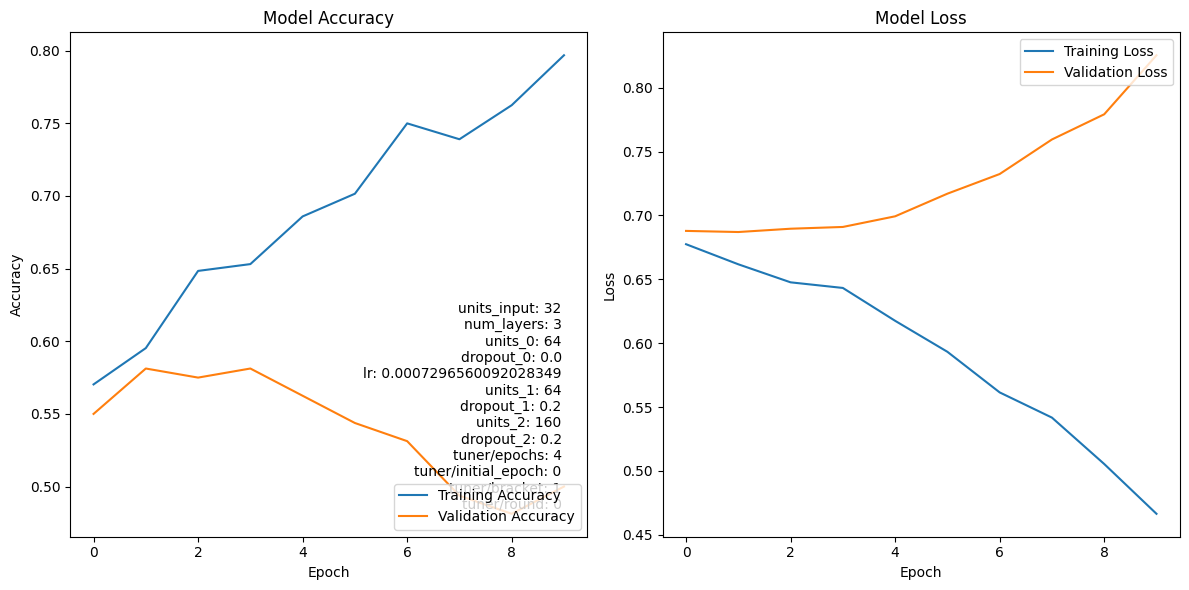

In [47]:
import matplotlib.pyplot as plt
import pandas as pd

# ... (Previous code to define tuner, best_model, history) ...

# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

# Extract hyperparameter values
hp_values = best_hp.values
hp_text = "\n".join([f"{k}: {v}" for k, v in hp_values.items()])

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)  # Create a subplot for accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Add hyperparameter information as text
plt.text(0.95, 0.05, hp_text, ha='right', va='bottom', transform=plt.gca().transAxes, fontsize=10)

# Plot training and validation loss
plt.subplot(1, 2, 2)  # Create a subplot for loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

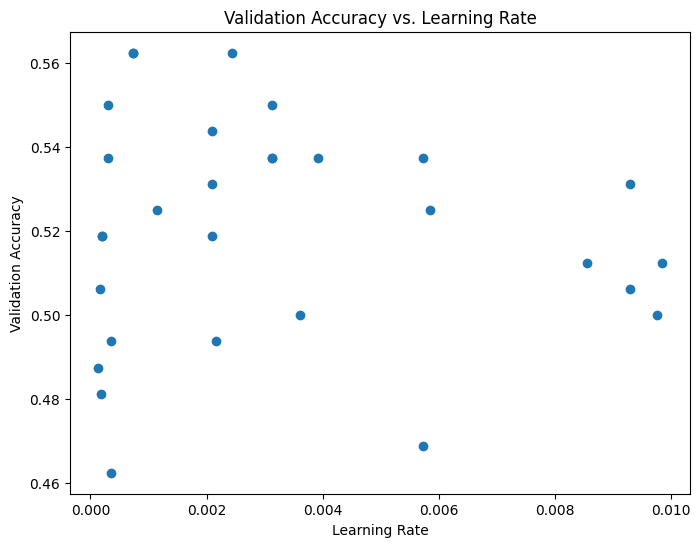

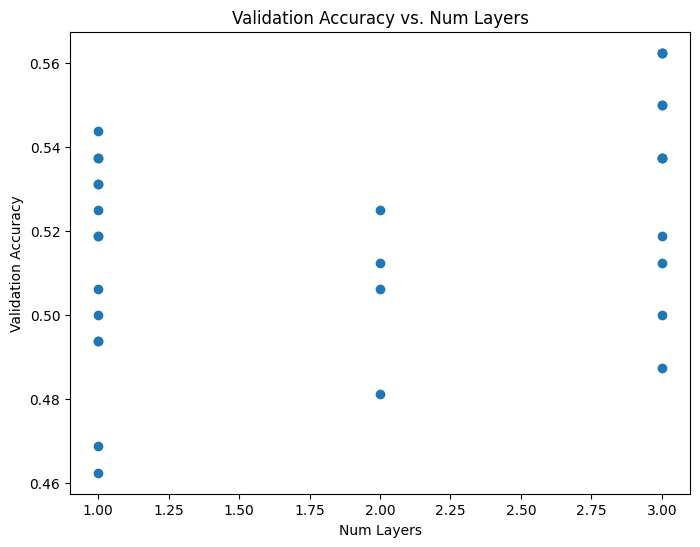

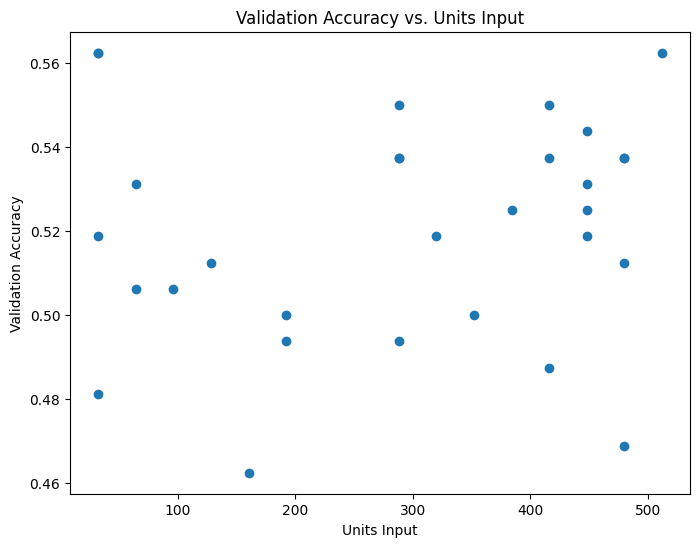

In [48]:
import matplotlib.pyplot as plt
import pandas as pd

# ... (Previous code to define tuner) ...

# Get all trials
trials = tuner.oracle.get_best_trials(num_trials=len(tuner.oracle.trials))  # Get all trials

# Store trial data in a list for easy conversion to DataFrame
trial_data = []

# Iterate over trials and extract data
for trial in trials:
    trial_info = {
        'Trial ID': trial.trial_id,
        'Validation Accuracy': trial.metrics.get_last_value('val_accuracy'),
        'Learning Rate': trial.hyperparameters.get('lr'),
        'Num Layers': trial.hyperparameters.get('num_layers'),
        'Units Input': trial.hyperparameters.get('units_input'),
        # Add other hyperparameters here if needed
    }
    trial_data.append(trial_info)

# Convert to DataFrame
df_trials = pd.DataFrame(trial_data)

# Plot Validation Accuracy vs. each hyperparameter
hyperparameters = ['Learning Rate', 'Num Layers', 'Units Input']  # Add other hyperparameters

for hp in hyperparameters:
    plt.figure(figsize=(8, 6))
    plt.scatter(df_trials[hp], df_trials['Validation Accuracy'])
    plt.title(f'Validation Accuracy vs. {hp}')
    plt.xlabel(hp)
    plt.ylabel('Validation Accuracy')
    plt.show()

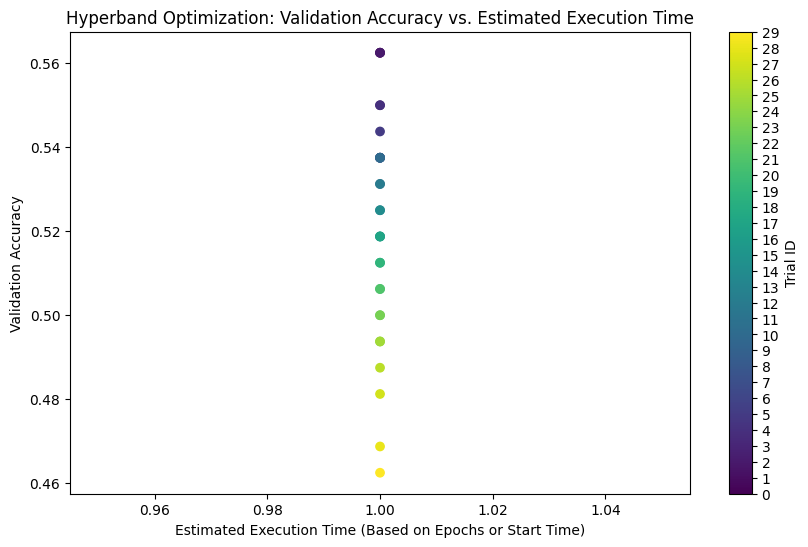

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import time

# ... (Previous code to define tuner) ...

# Get all trials
trials = tuner.oracle.get_best_trials(num_trials=len(tuner.oracle.trials))

# Extract trial data
trial_ids = [trial.trial_id for trial in trials]
val_accuracies = [trial.metrics.get_last_value('val_accuracy') for trial in trials]

# Calculate execution times using an alternative method
# Assuming 'metrics' stores the history per epoch, calculate time based on number of epochs
execution_times = [len(trial.metrics.get_history('val_accuracy')) for trial in trials]

# Or if you have access to the start time of the trial
# execution_times = [(time.time() - trial.start_time) if trial.start_time else None for trial in trials]

# Create a scatter plot
plt.figure(figsize=(10, 6))
# Convert trial_ids to numerical values for color mapping
# Here, we use the index of each trial ID as a numerical representation
numerical_trial_ids = list(range(len(trial_ids)))
plt.scatter(execution_times, val_accuracies, c=numerical_trial_ids, cmap='viridis')
plt.title('Hyperband Optimization: Validation Accuracy vs. Estimated Execution Time')
plt.xlabel('Estimated Execution Time (Based on Epochs or Start Time)')
plt.ylabel('Validation Accuracy')
# Use numerical_trial_ids in the colorbar for better representation
plt.colorbar(label='Trial ID', ticks=numerical_trial_ids)
plt.show()